# Model Feature Extraction

In [5]:
import tensorflow as tf
import numpy as np

model_path = 'food_101_model.tflite'
labels_path = 'food_101_labels.txt'

try:
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("Input details:")
    for detail in input_details:
        print(f"  name: {detail['name']}")
        print(f"  index: {detail['index']}")
        print(f"  shape: {detail['shape']}")
        print(f"  dtype: {detail['dtype']}")
        print(f"  quantization: {detail['quantization']}")
        print("-" * 20)

    input_shape = input_details[0]['shape']
    print(f"Supported image resolution (Height, Width): ({input_shape[1]}, {input_shape[2]})")

except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
except Exception as e:
    print(f"An error occurred during model loading: {e}")

try:
    with open(labels_path, 'r') as f:
        class_labels = [line.strip() for line in f.readlines()]
    print(f"\nSuccessfully loaded {len(class_labels)} class labels.")
except FileNotFoundError:
    print(f"Error: Class labels file not found at {labels_path}")
except Exception as e:
    print(f"An error occurred during labels loading: {e}")

Input details:
  name: input
  index: 0
  shape: [  1 192 192   3]
  dtype: <class 'numpy.uint8'>
  quantization: (0.0078125, 128)
--------------------
Supported image resolution (Height, Width): (192, 192)

Successfully loaded 2024 class labels.


# Model Experimentation with sample image

Model input shape: [  1 192 192   3]
Supported image resolution (Height, Width): (192, 192)
Running inference on sample.jpg...
Inference successful.
Output data shape: (1, 2024)

Top Predictions:
- Wrap: 71.48%
- Fajita: 8.20%
- Shawarma: 7.03%
- Burrito: 7.03%
- Gyro: 1.56%


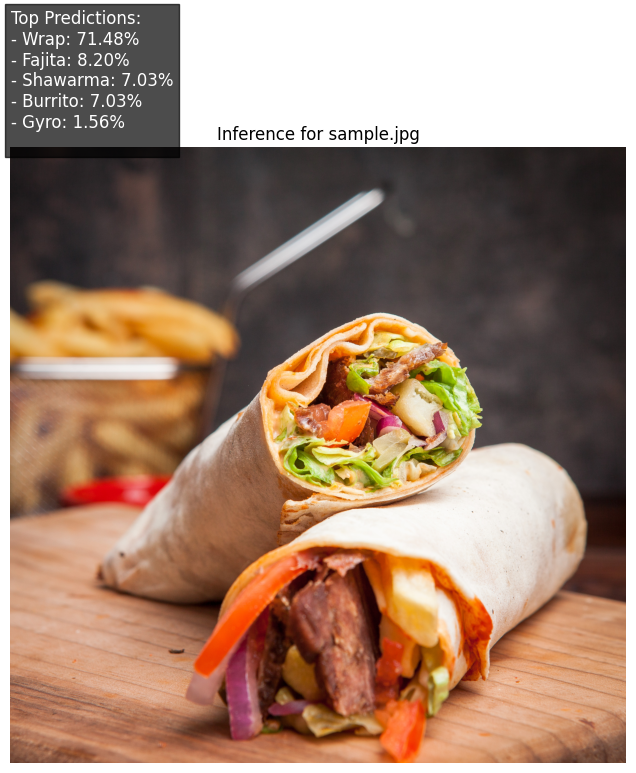

In [6]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import requests

model_path = 'food_101_model.tflite'
labels_path = 'food_101_labels.txt'
image_path = 'sample.jpg'

try:
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    print(f"Model input shape: {input_shape}")
    print(f"Supported image resolution (Height, Width): ({input_shape[1]}, {input_shape[2]})")

    try:
        img = Image.open(image_path).convert('RGB')

        resized_img = img.resize((input_shape[2], input_shape[1]))
        input_data = np.array(resized_img, dtype=np.float32)

        # Convert to UINT8 for the model compability
        if input_details[0]['dtype'] == np.uint8:
             input_data = input_data.astype(np.uint8)

        input_data = np.expand_dims(input_data, axis=0)

        interpreter.set_tensor(input_details[0]['index'], input_data)

        print(f"Running inference on {image_path}...")
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])
        print("Inference successful.")
        print(f"Output data shape: {output_data.shape}")

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Inference for {image_path}")

        try:
            with open(labels_path, 'r') as f:
                class_labels = [line.strip() for line in f.readlines()]

            # Process the output data
            if output_data.shape[0] > 0:
                predictions = output_data[0]

                output_scale, output_zero_point = output_details[0]['quantization']
                if output_scale > 0:
                    probabilities = (predictions - output_zero_point) * output_scale
                else:
                    probabilities = predictions

                # Get the top N predictions
                top_n = 5
                top_indices = np.argsort(probabilities)[::-1][:top_n]

                print("\nTop Predictions:")
                prediction_text = "Top Predictions:\n"
                for i in top_indices:
                    class_label = class_labels[i] if i < len(class_labels) else f"Unknown Class {i}"
                    probability = probabilities[i] * 100
                    prediction_text += f"- {class_label}: {probability:.2f}%\n"
                    print(f"- {class_label}: {probability:.2f}%")

                plt.text(5, 5, prediction_text, color='white', fontsize=12,
                         bbox=dict(facecolor='black', alpha=0.7))

            else:
                print("No output data available for processing.")
                prediction_text = "No predictions available."
                plt.text(5, 5, prediction_text, color='white', fontsize=12,
                         bbox=dict(facecolor='black', alpha=0.7))

        except FileNotFoundError:
            print(f"Error: Class labels file not found at {labels_path}. Cannot display predictions.")
            plt.text(5, 5, f"Error: Class labels file not found at {labels_path}.", color='red', fontsize=12,
                     bbox=dict(facecolor='black', alpha=0.7))
        except Exception as e:
            print(f"An error occurred while processing output data: {e}")
            plt.text(5, 5, f"An error occurred while processing output data: {e}", color='red', fontsize=12,
                     bbox=dict(facecolor='black', alpha=0.7))

        plt.show()

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred during image processing or inference: {e}")

except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
except Exception as e:
    print(f"An error occurred during model loading: {e}")